In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))

# Results loader object does everything
from ionpy.analysis import ResultsLoader
from pathlib import Path
root = Path("/storage/vbutoi/scratch/ESE")
rs = ResultsLoader()

# For using code without restarting.
%load_ext autoreload
%autoreload 
# For using yaml configs.
%load_ext yamlmagic

In [2]:
%%yaml results_cfg 

log:
    load_pixel_meters: True
    root: /storage/vbutoi/scratch/ESE/inference
    remove_shared_columns: True
    inference_paths:
        - "01_12_24_PixelStats/WMH_Individual_Uncalibrated"
        - "01_12_24_PixelStats/WMH_Individual_TempScaling"
        - "01_12_24_PixelStats/WMH_Individual_VectorScaling"
        - "01_12_24_PixelStats/WMH_Individual_DirichletScaling"
        - "01_12_24_PixelStats/WMH_Individual_LTS"
        - "01_12_24_PixelStats/WMH_Ensemble_Uncalibrated"
        - "01_12_24_PixelStats/WMH_Ensemble_TempScaling"
        - "01_12_24_PixelStats/WMH_Ensemble_VectorScaling"
        - "01_12_24_PixelStats/WMH_Ensemble_DirichletScaling"
        - "01_12_24_PixelStats/WMH_Ensemble_LTS"
    
calibration:
    conf_interval:
        - 0.5
        - 1.0
    num_bins: 10
    neighborhood_width: 3
    square_diff: False 
    ignore_index: 0

cal_metrics:
    - ECE:
        _fn: ese.experiment.metrics.ece.ece_loss
    - Edge_ECE:
        _fn: ese.experiment.metrics.ece.edge_ece_loss
    - CW_ECE:
        _fn: ese.experiment.metrics.ece.cw_ece_loss
    - ELM:
        _fn: ese.experiment.metrics.elm.elm_loss

<IPython.core.display.Javascript object>

In [3]:
from ese.experiment.analysis.inference import load_cal_inference_stats

inference_df = load_cal_inference_stats(
    results_cfg=results_cfg
)

In [4]:
inference_df.keys()

Index(['data_id', 'slice_idx', 'num_lab_0_pixels', 'num_lab_1_pixels',
       'cal_metric_type', 'cal_metric', 'qual_metric', 'cal_m_score',
       'cal_m_error', 'qual_score', 'conf_interval', 'num_bins',
       'neighborhood_width', 'square_diff', 'ignore_index', 'log_set',
       'experiment.pretrained_seed', 'log.root', 'model._class',
       'model.checkpoint', 'model.convs_per_block', 'model.ensemble',
       'model.ensemble_combine_fn', 'model.ensemble_pre_softmax',
       'model.in_channels', 'model.out_channels', 'model.pretrained_exp_root',
       'model._pretrained_class', 'model.image_channels', 'model.num_classes',
       'ECE', 'Edge_ECE', 'CW_ECE', 'ELM'],
      dtype='object')

In [5]:
len(inference_df)

156800

## We are going to remove the case where there are very few pixels, cause unrealistic outliers.

In [6]:
# Keep all of the columns where 'num_lab_1_pixels' is greater than 100.
pix_threshold = 100
thresholded_pix_df = inference_df[inference_df['num_lab_1_pixels'] > pix_threshold]

Text(0.5, 1.0, 'Histogram of number foreground pixels per image')

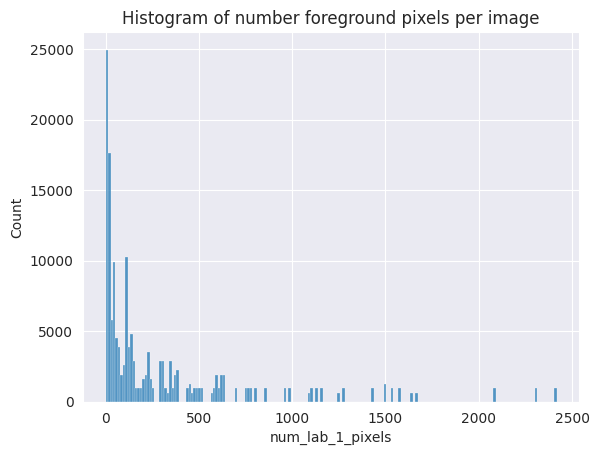

In [7]:
g = sns.histplot(inference_df['num_lab_1_pixels'])
g.set_title("Histogram of number foreground pixels per image")

## A few of the rows ofr HD95 are NaN, but not too many (about 5%).

In [8]:
# Get percent of rows with HD95 as the qual matric that have None for qual_score
total_hd_records = thresholded_pix_df[thresholded_pix_df['qual_metric'] == 'HD95']
num_hd_records = len(total_hd_records)
num_nan_hd__records = total_hd_records['qual_score'].isna().sum()
print("Total HD95 records: ", num_hd_records)
print("Total HD95 records with None qual_score: ", num_nan_hd__records)
print("Percent of HD95 records with None qual_score: ", num_nan_hd__records / num_hd_records)

Total HD95 records:  43360
Total HD95 records with None qual_score:  28
Percent of HD95 records with None qual_score:  0.0006457564575645757


In [9]:
# Drop the rows of raw_image_info_df that have None for qual_score
de_naned_image_info_df = thresholded_pix_df.dropna(subset=['qual_score'])
# Fill the rest of the NaN values with 'None'
image_info_df = de_naned_image_info_df.fillna('None')

In [10]:
image_info_df["ensemble"] = image_info_df["model.ensemble"]
image_info_df["pre_softmax"] = image_info_df["model.ensemble_pre_softmax"]
image_info_df["combine_fn"] = image_info_df["model.ensemble_combine_fn"]

image_info_df["pretrained_seed"] = image_info_df["experiment.pretrained_seed"]

image_info_df["model_class"] = image_info_df["model._class"]
image_info_df["pretrained_model_class"] = image_info_df["model._pretrained_class"]

def method_name(model_class, pretrained_model_class, pretrained_seed, ensemble, pre_softmax, combine_fn):
    if ensemble:
        softmax_modifier = "pre" if pre_softmax else "post"
        method_name_string = f"Ensemble ({combine_fn}, {softmax_modifier})" 
    else:
        if pretrained_model_class == "None":
            method_name_string = f"{model_class.split('.')[-1]} (seed={pretrained_seed})"
        else:
            method_name_string = f"{pretrained_model_class.split('.')[-1]} (seed={pretrained_seed})"

    return method_name_string

def model_class(model_class):
    if "UNet" in model_class:
        return "Uncalibrated"
    else:
        return model_class.split('.')[-1]

def configuration(method_name, model_class):
    return f"{method_name}_{model_class}"

image_info_df.augment(method_name)
image_info_df.augment(model_class)
image_info_df.augment(configuration)

## Let's looks at the calibration scores of our models.

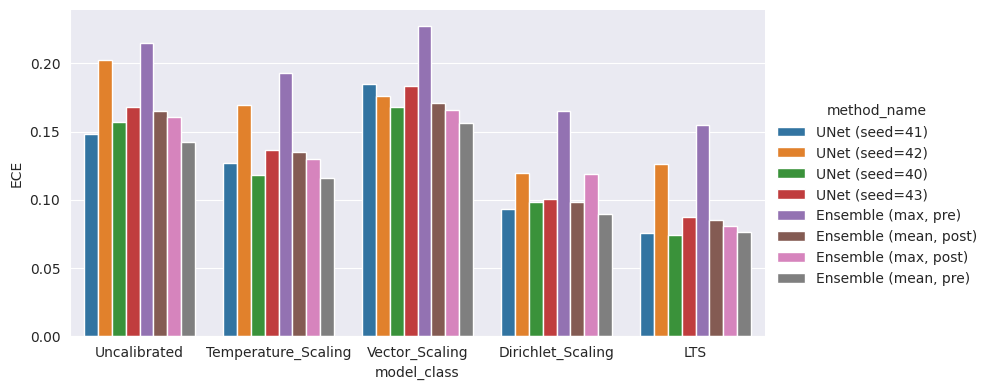

In [20]:
g = sns.catplot(
    data=image_info_df,
    x="model_class",
    y="ECE",
    hue="method_name",
    kind="bar",
    height=4,
    aspect=2
)

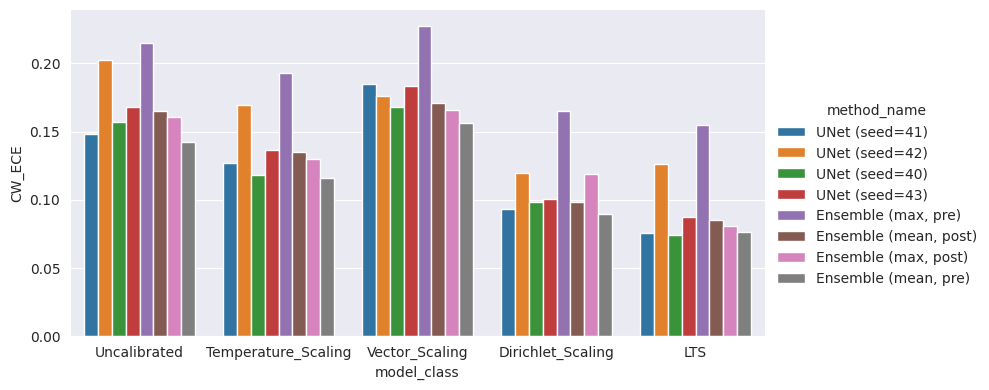

In [23]:
g = sns.catplot(
    data=image_info_df,
    x="model_class",
    y="CW_ECE",
    hue="method_name",
    kind="bar",
    height=4,
    aspect=2
)

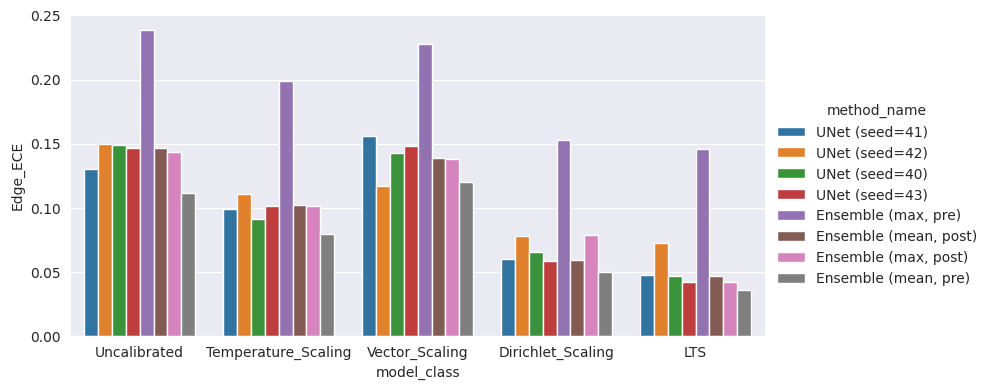

In [22]:
g = sns.catplot(
    data=image_info_df,
    x="model_class",
    y="Edge_ECE",
    hue="method_name",
    kind="bar",
    height=4,
    aspect=2
)

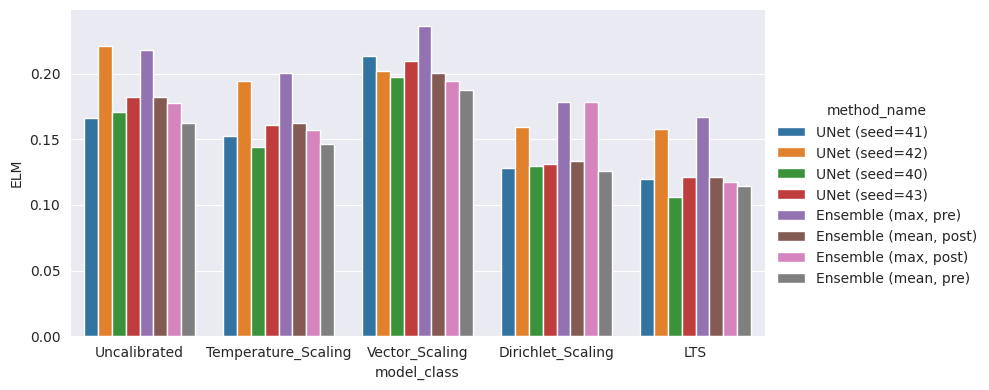

In [24]:
g = sns.catplot(
    data=image_info_df,
    x="model_class",
    y="ELM",
    hue="method_name",
    kind="bar",
    height=4,
    aspect=2
)

## Now we can look at the quality averages themselves, first looking slice-wise.

In [12]:
# table_df = image_info_df.groupby(["method_name", "model_class", "qual_metric", "ensemble"])['qual_score'].mean().reset_index()
dice_table = image_info_df[image_info_df["qual_metric"] == "Dice"]
hd95_table = image_info_df[image_info_df["qual_metric"] == "HD95"]

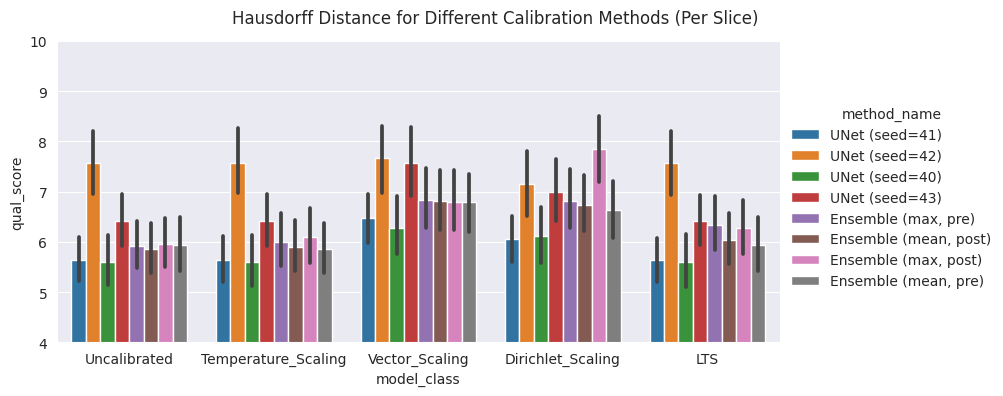

In [13]:
g = sns.catplot(
    data=hd95_table,
    x="model_class",
    y="qual_score",
    hue="method_name",
    kind="bar",
    height=4,
    aspect=2
)
# Set the title of the bar plot
g.fig.suptitle("Hausdorff Distance for Different Calibration Methods (Per Slice)")
# Give the title a bit of spacing from the plot
g.fig.subplots_adjust(top=0.90)
# Set the y axis to be between 4 and 8
g.set(ylim=(4, 10))

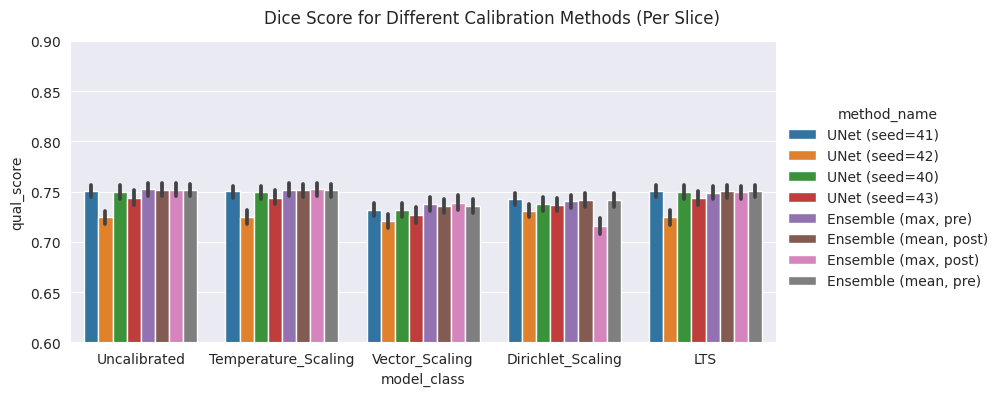

In [14]:
g = sns.catplot(
    data=dice_table,
    x="model_class",
    y="qual_score",
    hue="method_name",
    kind="bar",
    height=4,
    aspect=2
)
# Set the title of the bar plot
g.fig.suptitle("Dice Score for Different Calibration Methods (Per Slice)")
# Give the title a bit of spacing from the plot
g.fig.subplots_adjust(top=0.90)
# Set the y axis to be between 0.5 and 1.0
g.set(ylim=(0.6, 0.9))

## Now we want to consider these averaged within subjects.

In [15]:
subj_image_info_df = image_info_df.groupby(["method_name", "model_class", "qual_metric", "ensemble", "data_id"])['qual_score'].mean().reset_index()

subject_dice_table = subj_image_info_df[subj_image_info_df["qual_metric"] == "Dice"]
subject_hd95_table = subj_image_info_df[subj_image_info_df["qual_metric"] == "HD95"]

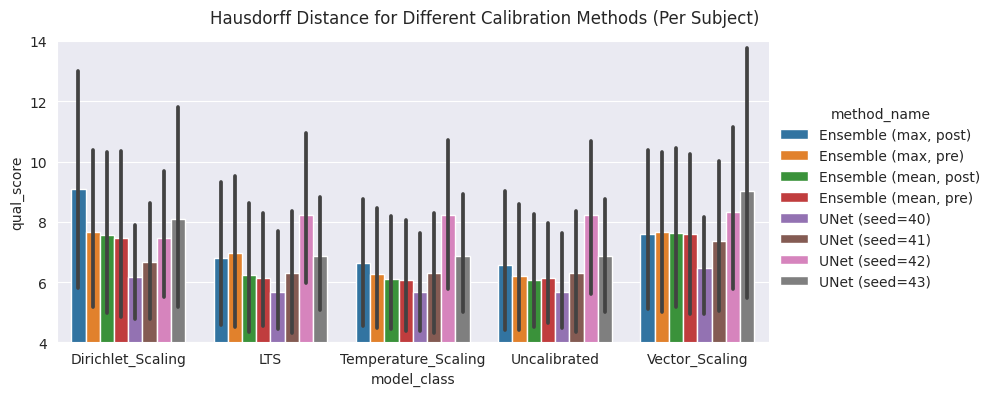

In [16]:
g = sns.catplot(
    data=subject_hd95_table,
    x="model_class",
    y="qual_score",
    hue="method_name",
    kind="bar",
    height=4,
    aspect=2
)
# Set the title of the bar plot
g.fig.suptitle("Hausdorff Distance for Different Calibration Methods (Per Subject)")
# Give the title a bit of spacing from the plot
g.fig.subplots_adjust(top=0.90)
# Set the y axis to be between 4 and 8
g.set(ylim=(4, 14))

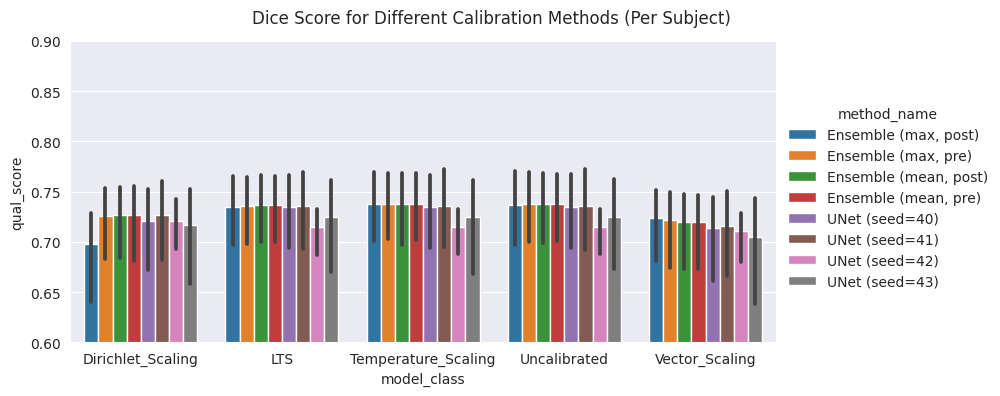

In [17]:
g = sns.catplot(
    data=subject_dice_table,
    x="model_class",
    y="qual_score",
    hue="method_name",
    kind="bar",
    height=4,
    aspect=2
)
# Set the title of the bar plot
g.fig.suptitle("Dice Score for Different Calibration Methods (Per Subject)")
# Give the title a bit of spacing from the plot
g.fig.subplots_adjust(top=0.90)
# Set the y axis to be between 0.5 and 1.0
g.set(ylim=(0.6, 0.9))

## Make some tables to show these relationships in

In [18]:
# Custom formatting function to display 3 significant digits
def format_sigfigs(x, num_sigfigs):
    if isinstance(x, (int, float)):
        format_str = '{:.' + str(num_sigfigs) + 'g}'
        return format_str.format(x)  # Using format to display in scientific notation with specified significant digits
    else:
        return x  # Return the value as is if it's not numeric

# Applying the formatting function to the pivot table
formatted_dice_table = dice_table.applymap(format_sigfigs, num_sigfigs=3)
# Applying the formatting function to the pivot table
formatted_hd95_table = hd95_table.applymap(format_sigfigs, num_sigfigs=4)

In [19]:
formatted_dice_table.pivot(index='method_name', columns='model_class', values='qual_score')

ValueError: Index contains duplicate entries, cannot reshape

In [ ]:
formatted_hd95_table.pivot(index='method_name', columns='model_class', values='qual_score')

## Let's look first at the distribution of errors per configuration.

In [ ]:
def build_ensemble_vs_individual_cmap(dice_image_df):
    # Build a custom color palette where each configuration is mapped to a color_map
    # corresponding to if it is an ensemble or individual model.
    num_individual_configurations = len(dice_image_df[dice_image_df['ensemble'] == False]['configuration'].unique())
    num_ensemble_configurations = len(dice_image_df[dice_image_df['ensemble'] == True]['configuration'].unique())
    # Define the palettes
    individual_palette = sns.color_palette("rocket", num_individual_configurations)
    ensemble_palette = sns.color_palette("mako", num_ensemble_configurations) 
    # Build the color map
    individual_colors = {}
    for i, configuration in enumerate(dice_image_df[dice_image_df['ensemble'] == False]['configuration'].unique()):
        individual_colors[configuration] = individual_palette[i]
    ensemble_colors = {}
    for i, configuration in enumerate(dice_image_df[dice_image_df['ensemble'] == True]['configuration'].unique()):
        ensemble_colors[configuration] = ensemble_palette[i]
    # Combine the two color maps
    return {
        **individual_colors,
        **ensemble_colors
    }

In [ ]:
dice_image_df = image_info_df[image_info_df['qual_metric'] == 'Dice']
# Use seaborn to create KDE plot for each configuration
g = sns.displot(
    data=dice_image_df.sort_values('configuration'), 
    x='qual_score', 
    hue='configuration', 
    kind='kde',
    palette=build_ensemble_vs_individual_cmap(dice_image_df),
    alpha=0.8
    )

In [ ]:
dice_image_subject_df = dice_image_df.groupby(['configuration', 'data_id'])['qual_score'].mean().reset_index()
g = sns.displot(
    data=dice_image_subject_df.sort_values('configuration'), 
    x='qual_score', 
    hue='configuration', 
    kind='kde',
    palette=build_ensemble_vs_individual_cmap(dice_image_df),
    alpha=0.8
    )